# Napkin math

We have a matrix $M_i = O_i + C_i$ comprising an offset term $O_i$ and a controllable term $C_i$.

If $||O_i|| = \alpha ||S_i||$, then:
$$\begin{align}
||M_1 M_2^T||^2 &= || O_1 O_2^T + O_1 C_2^T + C_1 O_2^T + C_1 C_2^T ||^2_2 \\
&= \langle O_1 O_2^T + O_1 C_2^T + C_1 O_2^T + C_1 C_2^T, O_1 O_2^T + O_1 C_2^T + C_1 O_2^T + C_1 C_2^T \rangle\\
&= \langle O_1 O_2^T, O_1 O_2^T + O_1 C_2^T + C_1 O_2^T + C_1 C_2^T \rangle
 + \langle O_1 C_2^T, O_1 O_2^T + O_1 C_2^T + C_1 O_2^T + C_1 C_2^T \rangle 
 + \langle C_1 O_2^T, O_1 O_2^T + O_1 C_2^T + C_1 O_2^T + C_1 C_2^T \rangle 
 + \langle C_1 C_2^T, O_1 O_2^T + O_1 C_2^T + C_1 O_2^T + C_1 C_2^T \rangle\\
&= \langle O_1 O_2^T, O_1 O_2^T \rangle + \langle O_1 O_2^T, O_1 C_2^T \rangle + \langle O_1 O_2^T, C_1 O_2^T \rangle + \langle O_1 O_2^T, C_1 C_2^T \rangle \\
&+ \langle O_1 C_2^T, O_1 O_2^T \rangle + \langle O_1 C_2^T, O_1 C_2^T \rangle + \langle O_1 C_2^T, C_1 O_2^T \rangle + \langle O_1 C_2^T, C_1 C_2^T \rangle \\
&+ \langle C_1 O_2^T, O_1 O_2^T \rangle + \langle C_1 O_2^T, O_1 C_2^T \rangle + \langle C_1 O_2^T, C_1 O_2^T \rangle + \langle C_1 O_2^T, C_1 C_2^T \rangle \\
&+ \langle C_1 C_2^T, O_1 O_2^T \rangle + \langle C_1 C_2^T, O_1 C_2^T \rangle + \langle C_1 C_2^T, C_1 O_2^T \rangle + \langle C_1 C_2^T, C_1 C_2^T \rangle \\
\end{align}
$$

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:25<00:00,  4.31s/it]


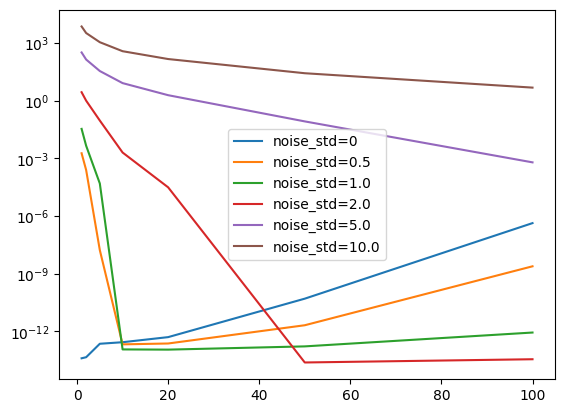

In [64]:
import jax
import jax.numpy as jnp
from tqdm import tqdm
import matplotlib.pyplot as plt

k1,k2,k3,k4 = jax.random.split(jax.random.PRNGKey(0), 4)
noise_std = 0.1
num_hidden = 1
num_steps = 10000

def loss(w, p1, p2, off1, off2):
    return jnp.mean((w-jnp.dot((off1 + jnp.tanh(p1)), (off2 + jnp.tanh(p2))) / len(p1) )**2)

@jax.jit
def train(w, p1, p2, off1, off2, lr=0.1):
    value_and_grad = jax.value_and_grad(loss, argnums=[1,2])
    
    def step(carry, _):
        p1, p2 = carry
        l, grad = value_and_grad(w, p1, p2, off1, off2)
        p1 = p1 - lr * grad[0]
        p2 = p2 - lr * grad[1]
        return (p1, p2), l
    
    _, losses = jax.lax.scan(step, (p1, p2), length=num_steps)

    return w, losses

w = jax.random.normal(k1, (num_hidden, num_hidden))

num_reps = 500
noise_levels = [0, 0.5, 1.0, 2.0, 5.0, 10.0]
hidden_nodes = [1, 2, 5, 10, 20, 50, 100]

for noise_std in tqdm(noise_levels):
    losses = []
    for num_hidden in hidden_nodes:
        l = 0
        for rep in range(num_reps):
            k1, k2, k3, k4 = jax.random.split(jax.random.PRNGKey(rep), 4)
            off1 = noise_std * jax.random.normal(k1,num_hidden)
            off2 = noise_std * jax.random.normal(k2,num_hidden)
            p1 = jax.random.normal(k3, (num_hidden,))
            p2 = jax.random.normal(k4, (num_hidden,))

            w, ll = train(w, p1, p2, off1, off2, lr=0.1)
            l += ll[-1]
        losses.append(l/num_reps)

    plt.semilogy(hidden_nodes, losses, label=f'noise_std={noise_std}')

plt.legend()

# Is it better to just average devices or have two layers?

100%|██████████| 6/6 [00:10<00:00,  1.69s/it]


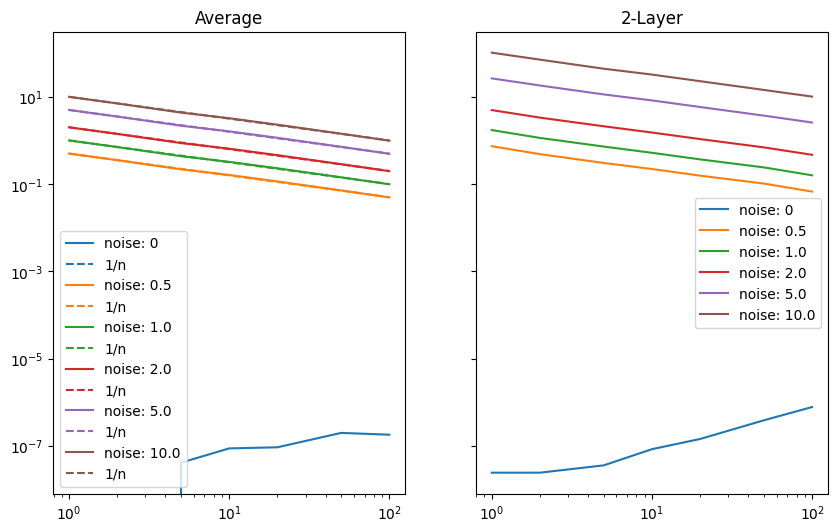

In [114]:
# each weigth is normally distributed

num_reps = 1000

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,6), sharex=True, sharey=True)
ax1.set_title("Average")
ax2.set_title("2-Layer")

for i,noise_std in enumerate(tqdm(noise_levels)):
    e1 = []
    e2 = []
    for num_hidden in hidden_nodes:
        _e1 = 0
        _e2 = 0
        for rep in range(num_reps):
            k1,k2,k3,k4 = jax.random.split(jax.random.PRNGKey(rep), 4)
            ww = jax.random.normal(k1, (1,))
            ww1 = jnp.sqrt(jnp.abs(ww))
            ww2 = ww / ww1

            _e1 += (jnp.mean(noise_std * jax.random.normal(k2, num_hidden) + ww)-ww)**2
            _e2 += (jnp.dot(noise_std * jax.random.normal(k3, num_hidden) + ww1, noise_std * jax.random.normal(k4, num_hidden) + ww2)/num_hidden - ww)**2

        e1.append(jnp.sqrt(_e1/num_reps))
        e2.append(jnp.sqrt(_e2/num_reps))

    ax1.loglog(hidden_nodes, jnp.array(e1), label=f'noise: {noise_std}', color=f"C{i}")
    ax1.loglog(hidden_nodes, noise_std*jnp.array(hidden_nodes)**-0.5, linestyle="dashed", color=f"C{i}", label='1/n')
    
    ax2.loglog(hidden_nodes, jnp.array(e2), label=f'noise: {noise_std}', color=f"C{i}")
    # ax2.loglog(hidden_nodes, 1.7*noise_std**1.9 *jnp.array(hidden_nodes)**-0.5, linestyle="dashed", color=f"C{i}", label='1.7/n')
ax1.legend()
ax2.legend()


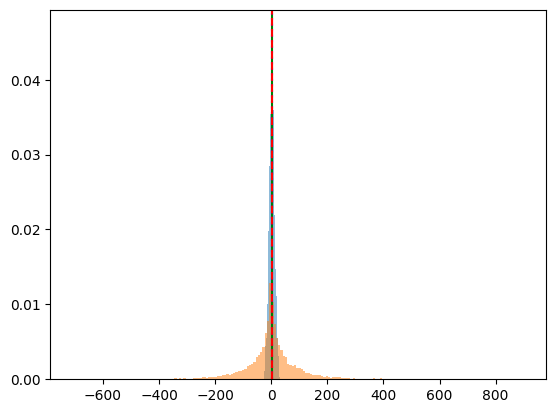

In [147]:
noise_std = 10.0
# each weight is a sum of deterministic part w and an offset part with std noise_std
# mean of n such iid variables w is normal with std noise_std/sqrt(n) with mean w
res1 = noise_std*jax.random.normal(k1, (10000,))+ww
plt.hist(res1, bins=200, density=True, alpha=0.5, label='normal');

# product of two weights ww1 = sqrt(w) and ww2 = w/sqrt(w) and std noise_std is distributed as a product-normal distribution
res2 = (noise_std*jax.random.normal(k1, (10000,))+ww1)*(noise_std*jax.random.normal(k2, (10000,))+ww2)
plt.hist(res2, bins=200, density=True, alpha=0.5, label='product-normal');


plt.axvline(jnp.mean(res2), color='g')
plt.axvline(jnp.mean(res1), color='b', linestyle='dotted')
plt.axvline(ww, color='r', linestyle='dashed')

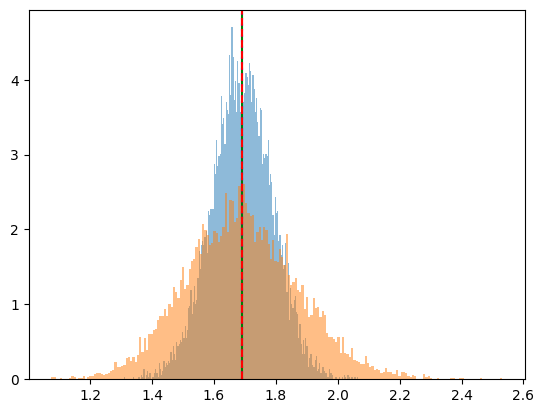

In [148]:
noise_std = 0.1
# each weight is a sum of deterministic part w and an offset part with std noise_std
# mean of n such iid variables w is normal with std noise_std/sqrt(n) with mean w
res1 = noise_std*jax.random.normal(k1, (10000,))+ww
plt.hist(res1, bins=200, density=True, alpha=0.5, label='normal');

# product of two weights ww1 = sqrt(w) and ww2 = w/sqrt(w) and std noise_std is distributed as a product-normal distribution
res2 = (noise_std*jax.random.normal(k1, (10000,))+ww1)*(noise_std*jax.random.normal(k2, (10000,))+ww2)
plt.hist(res2, bins=200, density=True, alpha=0.5, label='product-normal');


plt.axvline(jnp.mean(res2), color='g')
plt.axvline(jnp.mean(res1), color='b', linestyle='dotted')
plt.axvline(ww, color='r', linestyle='dashed')